In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import torch

torch.cuda.empty_cache()
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(torch.cuda.memory_allocated(device)/1024/1024/1024)
print(torch.cuda.memory_summary(device,abbreviated=True))

0.0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| GPU reserved memory   |       0 B  |       0 B  |       0 B  |       0 B  |
|-----------------------------------------------------------

In [5]:
import torch
from torch import nn

class View(nn.Module):
    def __init__(self,shape):
        super(View,self).__init__()
        self.shape = shape
    def forward(self,x):
        return x.reshape(*self.shape)
    
img = torch.rand(100)
View([10,10])(img).shape

torch.Size([10, 10])

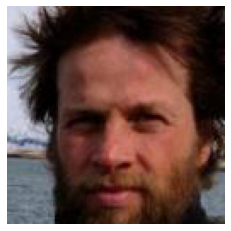

torch.Size([128, 128, 3])

In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

class Dataset(Dataset):
    def __init__(self,img_file):
        self.img_file = os.listdir(img_file)
        self.img_path = img_file
    def __len__(self):
        return len(self.img_file)
    
    def __getitem__(self,index):
        if index>len(self.img_file):
            raise IndexError()
        img = plt.imread(self.img_path+'\\'+self.img_file[index])
        img = self.crop_center(img)
        return torch.cuda.FloatTensor(img)/255.
    def crop_center(self,img,new_height=128,new_width=128):
        height,width,_ = img.shape
        dis_height = (height-new_height)//2
        dis_width = (width-new_width)//2
        return img[dis_height:dis_height+new_height,dis_width:dis_width+new_width,:]
    
    def plot_img(self,index):
        if index>len(self.img_file):
            raise IndexError()
        img = plt.imread(self.img_path+'\\'+self.img_file[index])
        img = self.crop_center(img)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
dataset = Dataset(r'E:\浏览器下载\img_align_celeba')
dataset.plot_img(10000)
dataset.__getitem__(10000).shape

In [15]:
class BasicConv(nn.Module):
    def __init__(self,inchanel,outchanel,kernersize,stride):
        super(BasicConv,self).__init__()
        self.conv1 = nn.Conv2d(inchanel,outchanel,kernel_size=kernersize,stride=stride,padding=kernersize//2)
        self.batchnorm = nn.BatchNorm2d(outchanel)
        self.relu = nn.LeakyReLU(0.2)
    def forward(self,x):
        x = self.batchnorm(self.conv1(x))
        return self.relu(x)
    
class BasicLinear(nn.Module):
    def __init__(self,inchanel,outchannel,act):
        super(BasicLinear,self).__init__()
        self.linear = nn.Linear(inchanel,outchannel)
        self.layernorm = nn.LayerNorm(outchannel)
        self.relu = nn.Sigmoid() if act=='sig' else nn.LeakyReLU(0.2)
    def forward(self,x):
        x = self.layernorm(self.linear(x))
        return self.relu(x)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View([1,3*10*10]),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        self.Linear = BasicLinear(16*16*3,1,'sig')
        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.parameters(),lr=0.001)
        self.counter = 0
        self.process = []
    def forward(self,x):
        x = x.permute(0,3,1,2)
#         print(x.shape)
        x = self.model(x)
        return x
    def train(self,input,target):
        output = self.forward(input)
        print(output,target)
        loss = self.loss(output,target)
        print('loss:',loss.item())
        self.counter += 1
        if self.counter % 100 == 0:
            self.process.append(loss.item())
        if self.counter % 1000 == 0:
            print('counter:',self.counter)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def plot_loss(self):
        plt.plot(self.process)
        plt.show()
        
def generate_random(size):
    arr = np.random.randn(*size)
    return torch.cuda.FloatTensor(arr)
    
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    
D = Discriminator().cuda()
dataset = DataLoader(dataset,batch_size=1 ,shuffle=True,drop_last=True)
for i,img in enumerate(dataset):
    D.train(img.cuda(),torch.cuda.FloatTensor([[1.0]]))
    D.train(generate_random([1,128,128,3]).cuda(),torch.cuda.FloatTensor([[0.0]]))

tensor([[0.5694]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.5631455183029175
tensor([[0.6731]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.1181104183197021
tensor([[0.5621]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.5760483741760254
tensor([[0.6493]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.0479117631912231
tensor([[0.6067]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.4997318387031555
tensor([[0.5160]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.7256025671958923
tensor([[0.7052]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.3492523431777954
tensor([[0.5713]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.8470149040222168
tensor([[0.5930]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.5226002931594849
tensor([[0.5421]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.7811988592147827
tensor([[0.7307]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.3138048052787781
tensor([[0.5168]], grad_fn=<SigmoidBackward>) tensor([

tensor([[0.0807]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.08410345762968063
tensor([[0.8604]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.1503276526927948
tensor([[0.0854]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.08925222605466843
tensor([[0.9971]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0029141406994313
tensor([[0.0640]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.06612039357423782
tensor([[0.9927]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.007332678884267807
tensor([[0.0640]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.06612472236156464
tensor([[0.9746]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.02577626332640648
tensor([[0.0439]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.044931747019290924
tensor([[0.9978]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.002249802928417921
tensor([[0.0438]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.04475906863808632
tensor([[0.0578]], grad_fn=<SigmoidBackwar

tensor([[0.9373]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.06479159742593765
tensor([[0.0157]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.015868617221713066
tensor([[0.9806]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.019568463787436485
tensor([[0.0168]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01698235422372818
tensor([[0.9995]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0004905473324470222
tensor([[0.0164]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.016521403566002846
tensor([[0.9878]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.012318233959376812
tensor([[0.0135]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01354413665831089
tensor([[0.9784]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.021843647584319115
tensor([[0.0200]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.02021114155650139
tensor([[0.7510]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.28638210892677307
tensor([[0.0510]], grad_fn=<SigmoidB

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.622607780722319e-06
tensor([[0.0351]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.03568495810031891
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.92487704125233e-05
tensor([[0.0261]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.026475945487618446
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.3589951777248643e-05
tensor([[0.0300]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.030481114983558655
tensor([[0.9350]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.06726045161485672
tensor([[0.0336]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.03419654443860054
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.099489549640566e-05
tensor([[0.0241]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.024412386119365692
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.438936154358089e-05
tensor([[0.0196]], grad_fn=<Si

tensor([[0.0300]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.03050944395363331
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.6703237381298095e-05
tensor([[0.0387]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.039467550814151764
tensor([[0.9998]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0001918857597047463
tensor([[0.0202]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.02043030597269535
tensor([[0.9833]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.01680067740380764
tensor([[0.0297]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.030175205320119858
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.622607780722319e-06
tensor([[0.0240]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.02432120218873024
tensor([[0.7955]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.22876107692718506
tensor([[0.0479]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.04909593611955643
tensor([[1.0000]], grad_fn=<Sigmoi

tensor([[0.0058]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005784100852906704
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0107]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.010759692639112473
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.152560215217818e-07
tensor([[0.0113]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011369542218744755
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.5644214221974835e-05
tensor([[0.0106]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.010686310939490795
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.3113030945532955e-06
tensor([[0.0080]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.007996438071131706
tensor([[0.9996]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0003533987619448453
tensor([[0.0146]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.014692909084260464
tensor([[1.0000]], grad_

tensor([[0.0262]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.02651585079729557
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.0609683158691041e-05
tensor([[0.0417]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.042586006224155426
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0373]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0379708968102932
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 9.155692532658577e-05
tensor([[0.0346]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.035209257155656815
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.707477662828751e-05
tensor([[0.0313]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.031754910945892334
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00013113881868775934
tensor([[0.0181]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.018216785043478012
tensor([[0.9931]], grad_fn=

tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 8.309232362080365e-05
tensor([[0.0033]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003290039487183094
tensor([[0.9988]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0012242536759003997
tensor([[0.0041]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004068773239850998
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.529963462118758e-06
tensor([[0.0032]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003207517322152853
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002305481117218733
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0033]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0032734747510403395
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 6.437322554120328e-06
tensor([[0.0034]], grad_

tensor([[0.9926]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.007441543508321047
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002310260431841016
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 8.940736734075472e-06
tensor([[0.0028]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002823460614308715
tensor([[0.9996]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00035244476748630404
tensor([[0.0038]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003836172167211771
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0043]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004265751224011183
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00013865000801160932
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002334336983039975
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.051804378628731e-05
tensor([[0.0049]], grad_

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768372718899627e-07
tensor([[0.0043]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004343930631875992
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.741851312748622e-05
tensor([[0.0041]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004115096293389797
tensor([[0.7734]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.2569222152233124
tensor([[0.0133]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.013341275975108147
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0139]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.013992656022310257
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0083]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.008292150683701038
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0089]], grad_fn=<SigmoidBackward>) ten

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0474]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.048591285943984985
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0117]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011790066957473755
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0110]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011093168519437313
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.6689314179529902e-06
tensor([[0.0145]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.014623956754803658
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.172333774477011e-06
tensor([[0.0119]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01200654823333025
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.960466182841628e-07
tensor([[0.0138]], grad_fn=<SigmoidBackward>) 

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0085]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00855446606874466
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0033966104965656996
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0041]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004154059570282698
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768372718899627e-07
tensor([[0.0031]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0031532240100204945
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0027042203582823277
tensor([[0.9974]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0025536809116601944
tensor([[0.0037]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003680915804579854
te

tensor([[0.0031]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003078485606238246
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.9908149624825455e-05
tensor([[0.0030]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0030390857718884945
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.57628505298635e-06
tensor([[0.0041]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004103365819901228
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0032]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0032463856041431427
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0055]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005536715965718031
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.0848104466276709e-05
tensor([[0.0028]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0027681123465299606
tensor([[1.]], grad_fn=<SigmoidBackward>) te

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003408512333407998
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0020]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0020505336578935385
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0046]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004638265818357468
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001765855704434216
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0039]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0039541712030768394
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.9073504518019035e-06
tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0025928225368261337
tensor([[1.0000]], grad_fn=<SigmoidBackward>

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 9.059946933120955e-06
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014315953012555838
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0029]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0029361394699662924
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015642950311303139
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013553143944591284
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.960466182841628e-07
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015917564742267132
tensor([[0.9861]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.013993622735142708
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013904697261750698

tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001550385495647788
tensor([[0.9997]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00025841951719485223
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009644508245401084
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012012183433398604
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000783213647082448
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 8.344653679159819e-07
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012898414861410856
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.006802894058637e-06
tensor([[0.0022]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0022276996169239283
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0

tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011355765163898468
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001418762025423348
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.5033982637978625e-06
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005998621927574277
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.152560215217818e-07
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000856766477227211
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.267783515388146e-05
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010637335944920778
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.117047789506614e-05
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017537346575409174
tensor([[1.0000]], gr

tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006543154013343155
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 6.198902156029362e-06
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010966112604364753
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.0728893357736524e-05
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005159516585990787
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000742770847864449
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00045816664351150393
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005820895312353969
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 

loss: 1.9073504518019035e-06
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000530741352122277
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00013972305168863386
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007089504506438971
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010899282060563564
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007662727730348706
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005316955503076315
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000808744749519974
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]]

tensor([[0.0057]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005759161897003651
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.9206701583461836e-05
tensor([[0.0077]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.007746343035250902
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0068]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.006791114807128906
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0165]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01667860709130764
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0127]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01278099324554205
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0143]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0144117446616292
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0043]], grad_fn=<

tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001100430148653686
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001782753737643361
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920935776288388e-06
tensor([[0.0050]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005045963916927576
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0025]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0025056374724954367
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.57628505298635e-06
tensor([[0.0040]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003975714091211557
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003433931153267622
tensor([[1.]], grad_fn=<SigmoidBackward>) tenso

tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012623884249478579
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013513751327991486
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017817984335124493
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014069436583667994
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.528657180140726e-05
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010524564422667027
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.152560215217818e-07
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001192744355648756
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[0.0116]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011644545011222363
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0188]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01900249719619751
tensor([[0.9952]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.004806607495993376
tensor([[0.0184]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.018566541373729706
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 9.536747711536009e-07
tensor([[0.0052]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005175129976123571
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.960466182841628e-07
tensor([[0.0132]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.013337288983166218
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0176]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.017788514494895935
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor

tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014626942574977875
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0026062685064971447
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.291543518775143e-06
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001104905386455357
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002115399343892932
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0022540444042533636
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768372718899627e-07
tensor([[0.0020]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019700846169143915
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0022]], gra

tensor([[0.0020]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0020417538471519947
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019214123021811247
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.6689314179529902e-06
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010161196114495397
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018180435290560126
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001441444270312786
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011470337631180882
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackwar

tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009938647272065282
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004799921589437872
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011371280997991562
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 9.775639773579314e-05
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005576973198913038
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001031513325870037
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0016658464446663857
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007527919369749725
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.319718133658171e-05
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012215084861963987
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005737400497309864
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009585443185642362
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00034785360912792385
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920935776288388e-06
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006535996799357235
tensor([[1.]], gra

tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002617025515064597
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.588264007703401e-05
tensor([[0.0073]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.007303258404135704
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0044]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004379670135676861
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00013519247295334935
tensor([[0.0049]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004909327253699303
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0050]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0050541115924716
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0052]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005232708994299173
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor(

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0037]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003746724920347333
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0040]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003999890759587288
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0031]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0030898454133421183
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001491108094342053
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0029]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0029092987533658743
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.960466182841628e-07
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019455988658592105

tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0022652156185358763
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.7881409348774469e-06
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002097480231896043
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019433893030509353
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0029]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002907864050939679
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.176656799856573e-05
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0016559356590732932
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015592804411426187
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-0

tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0023090059403330088
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00207346910610795
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.111410842393525e-05
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007756975828669965
tensor([[0.9942]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0057844603434205055
tensor([[0.0025]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002501215785741806
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 9.203380614053458e-05
tensor([[0.0037]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0037028715014457703
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.960482212685747e-06
tensor([[0.0030]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00298085599206388
tensor([[1.0000]], grad_fn=<SigmoidBackward>) te

tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007165256538428366
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1086525773862377e-05
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007360305171459913
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007174800266511738
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001403959235176444
tensor([[0.9819]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.01829138956964016
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010861094342544675
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.849142583727371e-05
tensor([[0.0028]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0028169455472379923
tensor([[1.]], grad_fn=<SigmoidBackward>) te

tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010059765772894025
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005757081671617925
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.98023678624304e-06
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003433816891629249
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768372718899627e-07
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008189454092644155
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.5020483260741457e-05
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011731708655133843
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.152560215217818e-07
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006503789336420596
tensor([[1.]], grad_fn=<SigmoidBackward>) t

loss: 0.007861260324716568
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001869995379820466
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0040]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004010124132037163
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0101]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.010105959139764309
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0025]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002481855684891343
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001658323802985251
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0025]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0025414905976504

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011228664079681039
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008643427863717079
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013984679244458675
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0090]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.009013501927256584
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007075786124914885
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009639735799282789
tensor([[1.0000]], grad_fn=<SigmoidBackwar

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008367819827981293
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007108591962605715
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010937470942735672
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006857480620965362
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0016074576415121555
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004409927933011204
tensor([[1.]], grad_fn=<SigmoidBackward>) 

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009927310748025775
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008043901179917157
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026611052453517914
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002643219195306301
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1324947081448045e-05
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009070574888028204
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.8835246009984985e-05
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00086535693844

tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00151128473225981
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001235353760421276
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00146102299913764
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0020]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019789235666394234
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0100]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.010003968141973019
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008683993946760893
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.0531240301788785e-06
tensor([[0.0012]], grad_fn=<SigmoidBackward>) t

tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005492288037203252
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005207821377553046
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005709966644644737
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008704873616807163
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0045]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004489710554480553
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015628025867044926
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000855811988003552
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007423533243127167
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018956074200104922
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005458890809677541
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004684830200858414
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001353881903924048
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005753503064624965
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.695494797284482e-06
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006841376889497042
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003249577130191028
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005203647306188941
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00038577604573220015
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006105975480750203
tensor([[1.]], grad_fn=<SigmoidBackward>)

tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007520760991610587
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036323704989627004
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006231818697415292
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003795748052652925
tensor([[0.0314]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.459642171859741
tensor([[0.9542]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.0841331481933594
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014616198604926467
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0038]], grad_fn=<SigmoidBackward>) te

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0024]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002378309378400445
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001052933745086193
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006168598774820566
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002340430859476328
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018353008199483156
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.6689314179529902e-06
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001017969218082726
tensor([[1.]], grad_fn=<SigmoidBackward>) ten

tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004636528028640896
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001319682807661593
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0020591942593455315
tensor([[0.9838]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.016347626224160194
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012621496571227908
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015502661699429154
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008284900104627013
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0020]], grad_fn=<SigmoidBackward>

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027517290436662734
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009377822279930115
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008665500208735466
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005394482868723571
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000722251832485199
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026169861666858196
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 

tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013454663567245007
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0031]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0030671856366097927
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0043]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00427670544013381
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00038577604573220015
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007216553203761578
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017995923990383744
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036347555578686297
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006940984749235213
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005103459698148072
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006595640443265438
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00106981978751719
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004478503542486578
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0033]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0033191628754138947
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001499644247815013
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006527646328322589
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019100657664239407
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000815485545899719
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0025]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002543342998251319
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0


tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0063]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.006335016805678606
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014912871411070228
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001354359439574182
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 5.781817526440136e-05
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010657623643055558
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017486594151705503
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018465270986780524
tensor([[1.]], grad_fn=<SigmoidBackward>) te

tensor([[0.0056]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005639391019940376
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0099]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.009963752701878548
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0076]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.007619186770170927
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0026096152141690254
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0050]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0049889348447322845
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011127223260700703
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0028]], grad_fn=<SigmoidBackward>

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001594323548488319
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013359764125198126
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00118874607142061
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000730841129552573
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001286678365431726
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010689247865229845
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
te

tensor([[0.0029]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002912705997005105
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006080329767428339
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0016450099647045135
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012977792648598552
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002664655912667513
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015692500164732337
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss:

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.861027041944908e-06
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007342410972341895
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004901895299553871
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000747542770113796
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007649604813195765
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008644023910164833
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006276550120674074
tensor([[1.]], grad_fn=<SigmoidBackward>) t

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009139779140241444
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006989298271946609
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009410039056092501
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00047074907342903316
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001304881414398551
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004446899110917002
tensor([[1.]], grad_fn=<SigmoidBackward>)

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004850609984714538
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010650462936609983
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023826815595384687
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005961048882454634
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00041463624802418053
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000855811988003552
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 

tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007604270940646529
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005359297501854599
tensor([[0.9857]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.014404972083866596
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000561752705834806
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015915706171654165
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005529263289645314
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.2649790025752736e-06
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004981805104762316
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], g

tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008814642205834389
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 6.198902156029362e-06
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022926574456505477
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003380750713404268
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000970059132669121
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004683041188400239
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005138047854416072
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackwar

loss: 1.0728841743912199e-06
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005273420829325914
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030766689451411366
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003291314060334116
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013513285375665873
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011678598821163177
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00043848829227499664
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<Sigm

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021406318410299718
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004603134002536535
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005469625466503203
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012033666716888547
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003697959764394909
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00059055833844468
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.

tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019018246093764901
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0104]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.010481077246367931
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0046]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004589523188769817
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002739124232903123
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.915810419945046e-05
tensor([[0.0057]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005718037486076355
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0086]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.008672061376273632
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0200]], grad_fn=<SigmoidBackward>) t

tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008521729614585638
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0024]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0023989223409444094
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005604407051578164
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010827082442119718
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018653972074389458
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0036]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0036430475302040577
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
los

tensor([[0.0022]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0021975922863930464
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014712302945554256
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0030]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003048292826861143
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000542907218914479
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0016805934719741344
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006240168586373329
tensor([[0.9635]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0371425561606884
tensor([[0.0023]], grad_fn=<SigmoidBackward>) t

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012413215590640903
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013015392469242215
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010434467112645507
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001998743537114933
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0027314142789691687
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012403667205944657
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0

tensor([[0.0110]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011100823059678078
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006149513646960258
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012967645889148116
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000913321680855006
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003255539631936699
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007727746851742268
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss:

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015891861403360963
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007046558894217014
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00039567428757436574
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00040628816350363195
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001968339056475088
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007409813697449863
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007690167403779924
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001489034912083298
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00046937749721109867
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0026903548277914524
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030230084666982293
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036860344698652625
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001587993756402284
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008566471515223384
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009726245771162212
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022276736854109913
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005244795465841889
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00046198308700695634
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0003]], grad_fn=<SigmoidBack

tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009531747782602906
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011546086170710623
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006760259275324643
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016851653344929218
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004066459368914366
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005358104826882482
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
l

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000769314996432513
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030242008506320417
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017435879271943122
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018383761926088482
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00034946348750963807
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017090111214201897
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
los

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004099851648788899
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003826158063020557
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006673774332739413
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019486657402012497
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000280658045085147
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.2981e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.29899334651418e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])


tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023087543377187103
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00029699443257413805
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768372718899627e-07
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016726461763028055
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.0094e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.012628288473934e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00045560247963294387
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003087400982622057
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.

tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009510866366326809
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010729822097346187
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0053]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0053052715957164764
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00034487232915125787
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00044963930849917233
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008267600787803531
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0025]], grad_fn=<SigmoidBackward>) tensor([[0.]])
l

tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000626700755674392
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001951511250808835
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010322293965145946
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0021438912954181433
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007613814668729901
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005121350404806435
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss:

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0055]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0055627282708883286
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015949206426739693
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003201281651854515
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004819600726477802
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011087078746641055
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00046997383469715714
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss:

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0115]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011578274890780449
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0173]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.017429446801543236
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0096]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.009676933288574219
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0230]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.023273082450032234
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0070]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0070129395462572575
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0131]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.013136825524270535
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
te

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010319310240447521
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006633216398768127
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0040]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0040292744524776936
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015735483029857278
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0037]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003688214346766472
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002740020863711834
tensor([[1.]], grad_fn=<SigmoidBackward>) t

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001169769442640245
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008287883247248828
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017024456756189466
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0084]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.008409775793552399
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002432165201753378
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008267600787803531
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007367462967522442
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008797938353382051
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005630051018670201
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00033771732705645263
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0037]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003734280588105321
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008318903273902833
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00029377485043369234
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002479860559105873
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005522106657736003
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002698064548894763
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0029]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0029460033401846886
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036592024844139814
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
lo

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00041553069604560733
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004047378315590322
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005831033922731876
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006231818697415292
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002590157091617584
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006693457253277302
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
lo

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.5864e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.584885992808267e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021609017858281732
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003265675622969866
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016499926277901977
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024733025929890573
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026944928686134517
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009923134930431843
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010878439206862822
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001167501788586378
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015878163976594806
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00029365558293648064
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022217119112610817
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss:

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00043860755977220833
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030373179470188916
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007527322741225362
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000163806980708614
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001346559583907947
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.8361e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.838317833375186e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]]

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00025561737129464746
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026968776364810765
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024482625303789973
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021728253341279924
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00031345034949481487
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001518245553597808
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
lo

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012380651605781168
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011858816724270582
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020875725022051483
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017286841466557235
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004414698341861367
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000388518936233595
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss:

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002684357459656894
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019021650950890034
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00028405647026374936
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00045142826274968684
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005260300822556019
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005613352404907346
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.8863e-05]], grad_fn=<SigmoidBackward>) tensor([[0.

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00028972054133191705
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014383635425474495
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003576322051230818
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026801839703693986
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001401999470544979
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020619372662622482
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
los

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010395590652478859
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001669069315539673
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030420877737924457
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.8483e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.850534267257899e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036902082501910627
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000688789994455874
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
l

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021865374583285302
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00040259119123220444
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00037355246604420245
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00034862873144447803
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014634011313319206
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003071302780881524
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
lo

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.3113030945532955e-06
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00028852809919044375
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027690190472640097
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.4150e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.416530181420967e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030426838202401996
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013906729873269796
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010383668268332258
tensor([[1.]], grad_fn=<SigmoidB

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004105218395125121
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001918857597047463
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00029896196792833507
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003122578782495111
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022950422135181725
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018753379117697477
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002121554280165583
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012780052202288061
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.8656e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.865269122296013e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00032865439425222576
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018103569163940847
counter: 10000
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.2103e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.209341806126758e-05
tensor([[1.]], grad_fn=<SigmoidBackwar

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021066500630695373
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024744949769228697
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013894807489123195
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.1219479094725102e-05
tensor([[6.1152e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.115623546065763e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013626550207845867
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.7248e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.723630212945864e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<S

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019283962319605052
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015015537792351097
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.1147e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.115623546065763e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016821845201775432
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010997661593137309
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011832221935037524
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.5968e-05]], grad_fn=<SigmoidBackward>) tenso

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020434560428839177
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013489440607372671
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.1668e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.1696325347875245e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.7764e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.7762342395144515e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.9898e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.9921979148639366e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.1595e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.15909601340536e-05
tensor([[0.9977]], grad_fn=<SigmoidBackward>

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.6353e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.634216697420925e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00025490194093436003
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.4967e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.49569922441151e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.9618e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.960432362277061e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.0219e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.024550672620535e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.1846e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.184333738521673e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) te

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00025335184182040393
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00037158478517085314
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5384e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.540578472893685e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003570359549485147
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.7100e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.707477662828751e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014228641521185637
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.9633e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.9651902372715995e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.0824e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.08300147682894e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011903756239917129
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.9660e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.966393554350361e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023582378344144672
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001483669620938599
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001383519556839019
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014574397937394679
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.2469e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.248187466757372e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.3428e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.342490006412845e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5501e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.552499765646644e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7700e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.771654362732079e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tenso

tensor([[3.7473e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.749202369363047e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0887e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.087243284331635e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.8950e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.893408812582493e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.1966e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.1994355847709812e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017888953152578324
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016154164040926844
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>)

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.9423e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.939653733046725e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.8937e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.895073263673112e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.8981e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.896495324326679e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001409749238518998
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005930035840719938
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.0663e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.0665232265600935e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tenso

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00025555776664987206
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005492884083651006
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.6938e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.695556370075792e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.2448e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.246761768124998e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.3331e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.336174556054175e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015641482605133206
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.5312e-05]], grad_fn=<SigmoidBackward>) 

tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002588161500170827
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00039680724148638546
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008031970355659723
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0045]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004469653125852346
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001257912372238934
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00048315274761989713
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0041]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016619155940134078
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004504145181272179
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009493564139120281
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021322854445315897
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019570119911804795
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006922494503669441
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021346702123992145
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0044]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004375299904495478
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005964626907370985
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002303984947502613
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011506141163408756
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003013468813151121
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002793463645502925
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017109836917370558
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001582144876010716
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024333575856871903
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018359915702603757
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002399970981059596
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
lo

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00035828808904625475
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003869089705403894
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003774878568947315
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023934128694236279
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022455590078607202
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001394845894537866
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])


tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024923807359300554
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004417679738253355
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.8261e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.827837882563472e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001954627368832007
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018264530808664858
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015248030831571668
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])


tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.3934e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.392958726384677e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002650969836395234
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.9273e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.926299829501659e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003268060681875795
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007021507481113076
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00032960838871076703
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]]

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011462630209280178
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001775183918653056
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024405118892900646
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.9912e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.991869304329157e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015492447710130364
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001487842673668638
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.

tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005473204073496163
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001909915154101327
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023880471417214721
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000722609693184495
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001205278531415388
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.8513e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.8519359552301466e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]]

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.3553e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.355797889526002e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002680780307855457
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005167865892872214
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.4085e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.407704495359212e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003587651008274406
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006444742321036756
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])

tensor([[4.7593e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.7565637942170724e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001435382873751223
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.2534e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.254148658830673e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003966283402405679
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019713198707904667
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013429828686639667
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.0886e-05]], grad_fn=<SigmoidBackward>) ten

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00034308357862755656
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768382950715022e-06
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011468591401353478
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.4357e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.4364822163770441e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000412608846090734
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018854725931305438
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013972305168863386
tensor([[1.]], grad_fn=<SigmoidBac

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.7732e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.774445915245451e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768382950715022e-06
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022467513917945325
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.1344e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.134930638130754e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.6384e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.638535266276449e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010878439206862822
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002738016191869974
tensor([[1.]], grad_fn=<Sigm

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001687549811322242
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.5774e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.580569606740028e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7904e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.787778354715556e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011617619747994468
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021155926515348256
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024077214766293764
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor(

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016106471593957394
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.9358e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.933693268569186e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.0087e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.006915671401657e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2100e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.2113566956249997e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003419507120270282
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010049848060589284
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) ten

tensor([[6.4532e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.45539112156257e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010556539928074926
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014407480193767697
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.8156e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.813043000875041e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019033574790228158
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.8862e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.889112435397692e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tens

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011420901864767075
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020959188987035304
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.5091e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.510467548854649e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.8559e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.85476916260086e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014246524369809777
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7622e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.7639354054117575e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) ten

tensor([[3.7552e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.755163197638467e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010866516822716221
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000129708118038252
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013686163583770394
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017048382142093033
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.4298e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.431547808460891e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([

tensor([[4.6423e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.6433095121756196e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.7513e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.75034456839785e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000229384982958436
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.6478e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.649007941130549e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001710203505354002
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001780549209797755
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.7503e-05]], grad_fn=<SigmoidBackward>) ten

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.2360e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.2379801016068086e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.1032e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.105450377915986e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.9743e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.976862591225654e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.2747e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.273466664832085e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013352332462091
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.5128e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.510467548854649e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) ten

tensor([[7.9697e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.969458238221705e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.5139694369281642e-05
tensor([[9.5676e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.567003144184127e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016607233555987477
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013191378093324602
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001243430160684511
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.3553e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.356920443475246e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.1878e-05]], grad

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003886382037308067
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003816021198872477
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002432761393720284
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.0072e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.005223935469985e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.7563e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.759395182598382e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.9954e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.9949940148508176e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021758062939625233
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016034934378694743
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.7424e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.742943125776947e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001520630030427128
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.8630e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.8656428437680006e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.6098e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.612106593209319e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) ten

tensor([[8.0018e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.999263470992446e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000250609329668805
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010318096610717475
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015242068911902606
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012601216440089047
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001218393153976649
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.2833e-05]], grad_fn=<SigmoidBackward>) tensor([

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.8967e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.896495324326679e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.3048e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.306370050879195e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011665309284580871
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003786803863476962
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.8363e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.83861297450494e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001675030798651278
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.3798e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.37964047503192e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 8.344653679159819e-07
tensor([[3.8037e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.802848732448183e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014496900257654488
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002938940888270736
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.9457e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.947057358454913e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013584821135737002
tensor([[1.]], grad_fn=<Sigmo

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024733025929890573
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.4846e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.48693247360643e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.6047e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.604412919841707e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027254957240074873
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.9751e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.977111530024558e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.0567e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.059158527525142e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.7871e-05]], grad_fn=<SigmoidBackward

tensor([[5.9824e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.984485324006528e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001452074502594769
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012660828360822052
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012124319619033486
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011707037629093975
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.1370e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.139829666703008e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.1600e-05]], grad_fn=<SigmoidBackward>) ten

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.2673e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.2695870282186661e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020458406652323902
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.480972009128891e-05
tensor([[1.0962e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.0967314665322192e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.2029e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.20503633399494e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00044296059058979154
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.0387e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.0381327784853056e-05
tensor([[1.]], grad_fn

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.3454e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.342490006412845e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011110922787338495
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.2098e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.2127420126926154e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 8.344653679159819e-07
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010097536869579926
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.4711e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.4736233172006905e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.3904e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.389822374330834e-05
tensor([[1.]], grad_fn

tensor([[6.4190e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.419626151910052e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.0136e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.014657366089523e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011444746633060277
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.0975e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.097741061239503e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.9995e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.999263470992446e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.5404e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.541977250482887e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.3480e-05]], grad_fn=<SigmoidBack

tensor([[3.5237e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.522696715663187e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.9015e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.8996218538377434e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.9163e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.916101923095994e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.9229e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.92487704125233e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.5935e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.593919872306287e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.4005e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.401744030881673e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.3841860752327193e-07
tensor([[0.0003]]

tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0033557030837982893
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008036146173253655
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005803003441542387
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018769224407151341
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0039]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00388410035520792
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0045]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004512282554060221
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00039698611362837255
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008150083012878895
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0053]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005273573566228151
counter: 15000
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007120521040633321
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0104]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.010449877940118313
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009557998855598271
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tens

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007376410649158061
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003767723392229527
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003767127054743469
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005346773541532457
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009050291264429688
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006885514594614506
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003587651008274406
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007391918916255236
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001450286217732355
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0033]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00332580110989511
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005887095467187464
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00046359316911548376
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019653582421597093
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00043652046588249505
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00038273504469543695
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006839587003923953
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000533186481334269
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.576279254957626e-07
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018246646504849195
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBack

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000104253958852496
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00046019413275644183
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003606731479521841
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7184e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.7162487792083994e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016821845201775432
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000188606878509745
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]]

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001504534448031336
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003896518610417843
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012493913527578115
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010824789205798879
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000409746658988297
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005725472583435476
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.7116e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]]

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002538287953939289
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.8122e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.814474520273507e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005992657970637083
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.4760e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.477587445871904e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022497323516290635
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019969549612142146
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.8513e-05]], grad_fn=<SigmoidBackward>) tens

tensor([[6.1183e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.115623546065763e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.9993e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.999263470992446e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004711068468168378
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027129752561450005
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004164251440670341
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006569993565790355
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[

tensor([[5.3104e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.31091500306502e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013680201664101332
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020047051657456905
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.2608e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.260427183704451e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002037494268734008
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019969549612142146
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([

loss: 9.537197911413386e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016458197205793113
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022676178195979446
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017400109209120274
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003319337556604296
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003151794080622494
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7247e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.722209607483819e-05
tensor([[1.]], grad_fn=<Sigmo

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004231036582496017
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7918e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.793739182990976e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.5272e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.5258905477821827e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00043025927152484655
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000158858994836919
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0574e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.057438779156655e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.1461e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.1444157280493528e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.5371e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.540272054029629e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010115419718204066
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012583332136273384
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021698445198126137
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010914206359302625
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026634903042577207
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020345134544186294
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004579877422656864
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.6908e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.689294579904526e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.7881409348774469e-06
tensor([[4.7581e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.7565637942170724e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.5008e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.501431486569345e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7566e-05]], gra

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.2973e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.29875677684322e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012583332136273384
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001913492160383612
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006143549107946455
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00031780285644344985
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004652628558687866
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
lo

tensor([[2.2990e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.30076584557537e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013847117952536792
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010818828013725579
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012708517897408456
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.3860e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.386724948650226e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.2486e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.251307084108703e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tens

tensor([[3.9973e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.999551699962467e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.6270e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.625427391147241e-05
tensor([[0.9943]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.005695438012480736
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014067685697227716
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.0132e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.011472992715426e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.0385e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.036472329171374e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003730754542630166
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.2869e-05]], gra

loss: 6.342135020531714e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7991e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.801457594614476e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014469954185187817
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.1567e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.1545299609424546e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010586345160845667
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5944e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.594224835978821e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.0533e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.051804378628731e-05
tensor([[1.]], gra

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.9272e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.926630804722663e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014473055489361286
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020249748195055872
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003449915675446391
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011575892131077126
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.94730775244534e-05
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010276368993800133
tensor([[1.]], grad_fn=<SigmoidBack

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001990397140616551
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026444115792401135
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007621569093316793
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005940771079622209
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.1819e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.179777872399427e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.3306e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.3287971240933985e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030164499185048044
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.4215e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.4241696489043534e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.9522e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.950143142603338e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013984227553009987
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008150679641403258
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010528144193813205
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.

tensor([[2.9073e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.908749047492165e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.9838e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.9862372684874572e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.6680e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.668562516802922e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.9609e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.958979742601514e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.1367e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.138052438269369e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020357058383524418
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackwar

tensor([[0.0041]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00408666767179966
tensor([[0.9999]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.951575389597565e-05
tensor([[0.0049]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00487111322581768
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015238206833600998
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0057]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005738239735364914
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002300641965121031
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0020925228018313646
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0033]], grad_fn=<SigmoidBackward>) te

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036085202009417117
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002572504570707679
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012753986520692706
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009016285766847432
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0033708936534821987
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007464094087481499
tensor([[0.9985]], grad_fn=<SigmoidBackward>) tensor([[1.]])
los

tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014055707724764943
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013822328764945269
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.5497220147153712e-06
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002318743849173188
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015295721823349595
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002586579939816147
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001146974042057991
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackwar

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000267302937572822
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023749310639686882
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0021249563433229923
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001954627368832007
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010422533378005028
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000971431378275156
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.

loss: 0.0
tensor([[0.0022]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0022044023498892784
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0059]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005904848221689463
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008799131610430777
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005205436027608812
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.2649790025752736e-06
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010039479238912463
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005359297501854599
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<Sigm

tensor([[9.8974e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.900821896735579e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023218704154714942
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00044534585322253406
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011800334323197603
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011179137509316206
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0028]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002769546816125512
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]]

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.98023678624304e-06
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0023256740532815456
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002800618240144104
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012378005776554346
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012696595513261855
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013441751070786268
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002490592305548489
tensor([[1.]], grad_fn=<SigmoidBackward>)

loss: 0.0
tensor([[5.4511e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.453973790281452e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003962705668527633
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015999165771063417
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001657742541283369
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004997309879399836
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011528202594490722
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.2318e-05]], grad_fn=<SigmoidBackward>

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017173572268802673
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00026712409453466535
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00031583529198542237
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016768192290328443
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00037909779348410666
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.1470e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.148286724463105e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]]

tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013657594099640846
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016947036783676594
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002406529092695564
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004339563602115959
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.3489e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.348096212605014e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010800945165101439
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003500597376842052
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002566309121903032
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005730243865400553
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000527282478287816
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0325e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.033595466054976e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.7955e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.798032649792731e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])


tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000205299467779696
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003889959480147809
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005266860825940967
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010162986582145095
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000351610011421144
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014568436017725617
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011403019016142935
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007879260811023414
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00033610747777856886
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022205195273272693
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013972305168863386
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.4861e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.486623508157209e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014157105761114508
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024411080812569708
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013286758621688932
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020559754921123385
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.7196e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.721989772515371e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.3924e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.394365871325135e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor

tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004848821263294667
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013453673454932868
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015987243386916816
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.6511e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.6506800319766626e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.1024e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.102043259190395e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.0426e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.039883085875772e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.6195e-05]], grad_fn=<SigmoidBackward>)

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013668279279954731
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.0933e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.094638178590685e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 8.344653679159819e-07
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006908776122145355
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013417906302493066
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.7975e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.796591671649367e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011635503324214369
tensor([[1.]], grad_fn=<Sigmoid

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014532668865285814
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.4171e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.417977707926184e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7543e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.752013748860918e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002003512781811878
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020678988948930055
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020768414833582938
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.5267e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.524094765656628e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.1113e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.1128048906102777e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.9080e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.906782361213118e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012458146375138313
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7872e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.789536301861517e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017877030768431723
tensor([[1.]], grad_fn=<SigmoidBackward>) ten

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023624110326636583
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.7733e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.7762342395144515e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.6110e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.612106593209319e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014997653488535434
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2862e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.288844552822411e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007542234961874783
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7043e-05]], grad_fn=<SigmoidBackward>)

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.5556e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.553898543235846e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[8.4571e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.458257070742548e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.0128e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.012876135879196e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.2036e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.20503633399494e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00036633762647397816
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001821683836169541
tensor([[1.]], grad_fn=<S

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002512055216357112
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016648962628096342
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.3099e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.3126869564293884e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012815819354727864
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.2005e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.200500112958252e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.3681e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.370522558223456e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor(

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011867989087477326
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.8520e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.85476916260086e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.7690e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.767084490391426e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2177e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.217317342001479e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.7332e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.733912156661972e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.6000e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.601319859735668e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.0985e-05]], grad_fn=<SigmoidBackw

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.4750e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.4722455489390995e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0731e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.075321627780795e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[5.7747e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.7758566981647164e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018735494813881814
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.9012e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.899369277060032e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015802439884282649
tensor([[1.]], grad_f

tensor([[2.2194e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.217317342001479e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.0848104466276709e-05
tensor([[3.6330e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.635949542513117e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00020714759011752903
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7604e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.75973306997912e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.8804e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.881486428435892e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.9485e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.9490908016450703e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.4108e-05]

tensor([[9.4436e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.441821748623624e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7319e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.7299300199956633e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013596743519883603
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.6663e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.6689440599293448e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00035262363962829113
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001580840180395171
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.7613e-05]], grad_fn=<SigmoidBackward>

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010109458526130766
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.9943e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.996775608859025e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.5066e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.505944424541667e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00013906729873269796
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010282330185873434
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2046e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.2053962311474606e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5416e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.540578472893685e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.5532e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.555693415866699e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.3403e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.340718780644238e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0618e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.063399971229956e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[5.6741e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.674523345078342e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023200818395707756
tensor([[1.]], grad_

tensor([[2.0078e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.0086967197130434e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001241045683855191
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.0194e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.0220011467463337e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.4278e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.430130477179773e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.9551e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.95326858072076e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001044327873387374
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) t

loss: 0.0
tensor([[3.1831e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.182938598911278e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.4344e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.433286474319175e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002160305593861267
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.0213e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.0233942854683846e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5493e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.546539301169105e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.0737e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.076755329966545e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<Sigmo

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00030850162147544324
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.3205e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.319718133658171e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.5924e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.595359395258129e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001306619233218953
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.2156e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.21413715230301e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024440890410915017
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.7650e-05]], grad_fn=<SigmoidBackward>) t

tensor([[2.3422e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.342490006412845e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012815819354727864
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7720e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.771654362732079e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010049848060589284
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.9388e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.941347287967801e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.4259e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.427325646043755e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.8786e-05]], grad_fn=<SigmoidBackwar

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017680300516076386
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024786681751720607
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 9.179157132166438e-06
tensor([[2.7346e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.7358906663721427e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000722251832485199
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.1345e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.1338690203265287e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.2217e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.222918455023319e-05
tensor([[1.]], grad_fn=<Sig

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00017686262435745448
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.2828e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.282526737777516e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0126e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.015712617430836e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014025956625118852
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010157147335121408
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.4496e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.450857810908929e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor(

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.5823e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.580569606740028e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.7182e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.7166285033454187e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016672808851581067
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.5956e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.5928356990334578e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.9853e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.9862372684874572e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.2009e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.2036208217032254e-05
tensor([[1.]], grad_fn=<SigmoidBackward

tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 3.2187024771701545e-05
tensor([[3.8114e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.808809196925722e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011432824248913676
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002498938993085176
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.8819e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.882938320515677e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.4615e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.463089888100512e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2809e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.2828839064459316e-05
tensor([[1.]], grad_fn=

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.3720e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.371939525706694e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.0807e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.080223748635035e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.2251e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.222918455023319e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011546086170710623
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.1749e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.173575381282717e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.1598e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.1622973033809103e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) 

loss: 8.505944424541667e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.6997e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.6987467461149208e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5156e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.5167358873877674e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.7544e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.7537724236026406e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.6485e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.6464813345228322e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.1366e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.134930638130754e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015176493616309017
tensor([[1.

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010276368993800133
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.9277e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.9252485799370334e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.6077e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.608954234048724e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.7318e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.73246171977371e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.9388e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.939653733046725e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.5659e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.5658201997866854e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) 

tensor([[3.7949e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.796887904172763e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.7060e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.708617679076269e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.9056e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.908416980877519e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.5578e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.556725566042587e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.6235e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.623724377481267e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.5206e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.522696715663187e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2863e-05]], grad_fn=<SigmoidB

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012446223990991712
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.5957e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.5928356990334578e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00031273486092686653
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.0045e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.0041192076168954e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.7146e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.713438491104171e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.3593e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.360371763643343e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.0309e-05]], grad_fn=<SigmoidBackw

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.1543e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.1545299609424546e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.4362e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.436091305455193e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.6251e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.6240282497601584e-05
tensor([[0.9995]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.00047277656267397106
tensor([[5.8624e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.865269122296013e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.2262e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.2232779883779585e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00014484977873507887
tensor([[1.]], gr

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001179049359052442
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.2957e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.2934291589772329e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.3171e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.3172712897357997e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.7496e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.752391835907474e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.6836e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.6836347135249525e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.6617e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.661191997001879e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.7583e-05]], grad_fn=<SigmoidBa

tensor([[1.7951e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.794115814846009e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.9844e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.9816695789340883e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[3.3757e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.3736796467565e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.2084e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.209581649978645e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.0772e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.0742631022585556e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[6.1273e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.127545202616602e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.0360e-05]], grad_fn=<SigmoidB

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.9246e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.923213317757472e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023421407968271524
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[4.4451e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 4.4466054532676935e-05
tensor([[0.9975]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0025344991590827703
tensor([[6.1294e-06]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 6.139297056506621e-06
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.4974e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.4974657208076678e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.7666e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.76822741702199e-05
tensor([[1.]], grad_

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010437318269396201
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.861027041944908e-06
tensor([[3.4285e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 3.427325646043755e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[2.6077e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 2.6107174562639557e-05
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[7.9383e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.939653733046725e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.9121e-06]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.89442014542874e-06
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.5350e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.5374246585415676e-

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002255657222121954
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012856042012572289
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0017]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017290152609348297
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0153]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.01544165425002575
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014107637107372284
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009169012191705406
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0


tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007205816800706089
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002115996554493904
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004996117204427719
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0032]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0031651228200644255
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001254756498383358
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015440576244145632
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss

tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005890077445656061
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001296485133934766
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006861059810034931
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021728253341279924
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011796157341450453
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005931228515692055
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
lo

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016493965813424438
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018397794337943196
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007287534535862505
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0028]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0028495818842202425
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007547603454440832
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016952997248154134
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.4370e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]

tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007279780111275613
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007227290188893676
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0023484963458031416
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0051]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005074719432741404
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0023]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002283496083691716
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002065047388896346
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0068]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 

tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0016067412216216326
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0026]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0026474441401660442
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008938133250921965
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005018778028897941
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0043]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004268564283847809
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0039]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003943998366594315
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0044]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss:

tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003792170318774879
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007064453093335032
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005808967398479581
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008010495803318918
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0053]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0052990997210145
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005891270120628178
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 

tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009046114864759147
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023701615282334387
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006419096025638282
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.5962e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.596808376954868e-05
counter: 23000
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018431830685585737
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023755272559355944
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0018]], grad_fn=<SigmoidBackward

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012814265210181475
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00023326017253566533
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00031875682179816067
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007267850451171398
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012605383526533842
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006205576355569065
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss:

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.1547e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.155692532658577e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006418499397113919
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.2082e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.209581649978645e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001391865371260792
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002460782416164875
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002301003987668082
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018353953782934695
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00037945553776808083
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00046347390161827207
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008053445490077138
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011642196914181113
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002970540663227439
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00011629542132141069
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00028852809919044375
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[7.0290e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 7.027634273981676e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000222946226131171
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003706307616084814
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 2.145769485650817e-06
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003051627427339554
tensor([[1.]], grad_fn=<SigmoidBackwa

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.9215e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.924665937433019e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003319337556604296
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024244147061835974
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[1.6965e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 1.6987467461149208e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019295884703751653
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003327088779769838
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.

tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00012762169353663921
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[5.4733e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 5.4718562751077116e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.8883e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.887447620509192e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.0752e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.076755329966545e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001837780000641942
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.0041e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.006667096400633e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) 

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0043]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004277663305401802
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0052]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.005196459591388702
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0047]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.004728691652417183
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0035]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003499364946037531
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0113]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.011315708048641682
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0047]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0047256373800337315
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
te

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001581906108185649
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 7.867844033171423e-06
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011602812446653843
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.4305124977909145e-06
tensor([[0.0061]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.006098410114645958
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0029]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00286733522079885
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0031]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0030635984148830175
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0013115658657625318


tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0030]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003046678612008691
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0034]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003400916699320078
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014999427367001772
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009754883940331638
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001922845607623458
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 1.1920930376163597e-07
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014631717931479216
tensor([[1.]], grad_f

tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005998025881126523
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006821693386882544
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008190647349692881
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003686630807351321
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003810058697126806
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0020]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019966615363955498
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
los

loss: 0.0
tensor([[0.0021]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0021354095079004765
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0020]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0019793417304754257
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005409392178989947
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0027516160625964403
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0033]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.003274790244176984
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000352683273376897
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0

tensor([[0.0018]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0017715281574055552
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007642447017133236
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0013]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0012545703211799264
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011046667350456119
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006784713477827609
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008239563321694732
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
los

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0016]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0015758168883621693
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0027]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.002672066679224372
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010680296691134572
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0014]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0014139271806925535
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0011]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0011454821797087789
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009164836374111474
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.

tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010107497218996286
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00019957625772804022
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00045673546264879405
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0012]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001243171631358564
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00034850946394726634
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008728139800950885
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
l

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00022610597079619765
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000667138840071857
tensor([[1.0000]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 4.768372718899627e-07
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0010318714193999767
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009152904385700822
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005284155486151576
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00038118474185466766
tensor([[1.]], grad_fn=<SigmoidBackward>)

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027916752151213586
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005587111809290946
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00047277656267397106
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008287883247248828
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004467770049814135
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00035697632119990885
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005485728033818305
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0010]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0009912395616993308
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005562063888646662
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00033795583294704556
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008334413287229836
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0009]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0008735895389690995
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 

loss: 0.0
tensor([[0.0015]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.001524775754660368
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0007]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006875970866531134
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00021966724307276309
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[8.4172e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 8.416530181420967e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0008]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0007683009025640786
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005528070614673197
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tens

tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002823870745487511
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015790517500136048
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005730840493924916
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002331409341422841
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00015695134061388671
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027916752151213586
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])


tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0019]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0018664720701053739
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[9.5655e-05]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 9.567003144184127e-05
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00042686035158112645
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00037140591302886605
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.000244468537857756
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00016941074864007533
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
l

tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00018598377937451005
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0001759683946147561
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0004]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00035638007102534175
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00028071767883375287
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00024899959680624306
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0006]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0006213926244527102
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])

tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0004959740326739848
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0001]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00010687683970900252
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0003067725629080087
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0005]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0005311588174663484
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0003]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.00027320539811626077
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss: 0.0
tensor([[0.0002]], grad_fn=<SigmoidBackward>) tensor([[0.]])
loss: 0.0002002916589844972
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]])
loss:

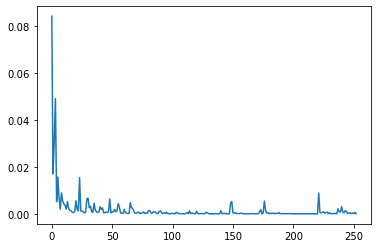

In [16]:
D.plot_loss()

tensor([[0.0001]], grad_fn=<SigmoidBackward>)

tensor([[1.]], grad_fn=<SigmoidBackward>)

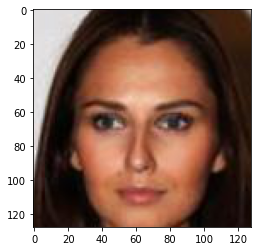

In [17]:
D(generate_random([1,128,128,3]))
D(img)
plt.imshow(img.cpu().detach().numpy()[0,:])
plt.show()

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

class View(nn.Module):
    def __init__(self,shape):
        super(View,self).__init__()
        self.shape = shape
    def forward(self,x):
        return x.reshape(*self.shape)

class Dataset(Dataset):
    def __init__(self,img_file):
        self.img_file = os.listdir(img_file)
        self.img_path = img_file
    def __len__(self):
        return len(self.img_file)
    
    def __getitem__(self,index):
        if index>len(self.img_file):
            raise IndexError()
        img = plt.imread(self.img_path+'\\'+self.img_file[index])
        img = self.crop_center(img)
        return torch.cuda.FloatTensor(img)/255.
    def crop_center(self,img,new_height=128,new_width=128):
        height,width,_ = img.shape
        dis_height = (height-new_height)//2
        dis_width = (width-new_width)//2
        return img[dis_height:dis_height+new_height,dis_width:dis_width+new_width,:]
    
    def plot_img(self,index):
        if index>len(self.img_file):
            raise IndexError()
        img = plt.imread(self.img_path+'\\'+self.img_file[index])
        img = self.crop_center(img)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        
def generate_random(size):
    arr = np.random.randn(*size)
    return torch.cuda.FloatTensor(arr)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View([1,3*10*10]),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.parameters(),lr=0.001)
        self.counter = 0
        self.process = []
    def forward(self,x):
#         x = x.permute(0,3,1,2)
#         print(x.shape)
        x = self.model(x)
        return x
    def train(self,input,target):
        output = self.forward(input)
#         print(output,target)
        loss = self.loss(output,target)
#         print('loss:',loss.item())
        self.counter += 1
        if self.counter % 100 == 0:
            self.process.append(loss.item())
        if self.counter % 1000 == 0:
            print('counter:',self.counter)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def plot_loss(self):
        plt.plot(self.process)
        plt.show()

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(nn.Linear(100,3*11*11),
                                   nn.LeakyReLU(0.1),
                                   View([1,3,11,11]),
                                   nn.ConvTranspose2d(3,256,kernel_size=8,stride=2),
                                   nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.1),
                                   nn.ConvTranspose2d(256,256,kernel_size=8,stride=2),
                                   nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.1),
                                   nn.ConvTranspose2d(256,3,kernel_size=8,stride=2,padding=1),
                                   nn.BatchNorm2d(3),
                                   nn.Sigmoid()
                                  )
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01)
        self.counter = 0
        self.process = []
    def forward(self,x):
        return self.model(x)
    def train(self,D,inputs,targets):
        outputs = self.forward(inputs)
        outputs = D(outputs)
        loss = D.loss(outputs,targets)
        
        if self.counter%100 == 0:
            self.process.append(loss.item())
        if self.counter & 1000 == 0:   
            print(self.counter)
        
        self.counter += 1
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_loss(self):
        plt.plot(self.process)
        plt.show()
        
G = Generator().cuda()
G(generate_random([100])).shape

torch.Size([1, 3, 128, 128])

In [3]:
D = Discriminator().cuda()
G = Generator().cuda()

dataset = Dataset(r'E:\浏览器下载\img_align_celeba')
dataset = DataLoader(dataset,batch_size=1,shuffle=True,drop_last=True)
for i,img in enumerate(dataset):
    D.train(img.permute(0,3,1,2).cuda(),torch.cuda.FloatTensor([[1.0]]))
    D.train(G(generate_random([100])).detach(),torch.cuda.FloatTensor([[0.0]]))
    G.train(D,generate_random([100]),torch.cuda.FloatTensor([[1.0]]))

d:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)


0
1
2
3
4
5
6
7
16
17
18
19
20
21
22
23
counter: 1000
counter: 2000
1024
1025
1026
1027
1028
1029
1030
1031
1040
1041
1042
1043
1044
1045
1046
1047
counter: 3000
counter: 4000
2048
2049
2050
2051
2052
2053
2054
2055
2064
2065
2066
2067
2068
2069
2070
2071
counter: 5000
counter: 6000
3072
3073
3074
3075
3076
3077
3078
3079
3088
3089
3090
3091
3092
3093
3094
3095
counter: 7000
counter: 8000
4096
4097
4098
4099
4100
4101
4102
4103
4112
4113
4114
4115
4116
4117
4118
4119
counter: 9000
counter: 10000
5120
5121
5122
5123
5124
5125
5126
5127
5136
5137
5138
5139
5140
5141
5142
5143
counter: 11000
counter: 12000
6144
6145
6146
6147
6148
6149
6150
6151
6160
6161
6162
6163
6164
6165
6166
6167
counter: 13000
counter: 14000
7168
7169
7170
7171
7172
7173
7174
7175
7184
7185
7186
7187
7188
7189
7190
7191
counter: 15000
counter: 16000
8192
8193
8194
8195
8196
8197
8198
8199
8208
8209
8210
8211
8212
8213
8214
8215
counter: 17000
counter: 18000
9216
9217
9218
9219
9220
9221
9222
9223
9232
9233
9234
9235

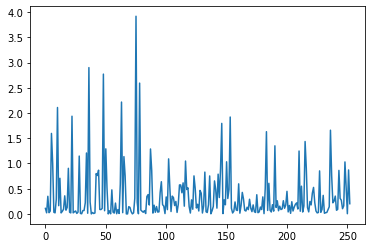

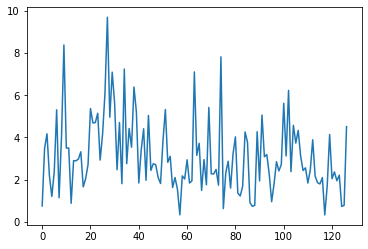

In [4]:
D.plot_loss()
G.plot_loss()

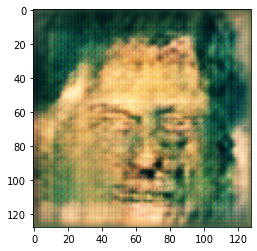

In [5]:
plt.imshow(G(generate_random([100])).permute(0,2,3,1).cpu().detach().numpy()[0,:])
plt.show()